# Atmospheric Rivers: Filtering by Criteria

This notebook will import functions from the `ar_detection.py` module to expose the processing flow and to show a few examples.
Production runs could also be orchestrated from this notebook to leverage the use of an interactive Dask client if/when needed. Before executing this notebook be sure you've set your `AR_DATA_DIR` environment variable, and have executed both the `download.py` and `compute_ivt.py` scripts.

In [1]:
import xarray as xr
import random
import matplotlib.pyplot as plt
from tqdm import tqdm

from config import ar_params, ard_fp

# functions to create the binary "blobs" of IVT exceedance
from ar_detection import compute_intensity_mask, label_contiguous_mask_regions
# functions to measure the requisite blob properties
from ar_detection import generate_region_properties, get_data_for_ar_criteria, get_azimuth_of_furthest_points, get_directional_coherence, get_length_width_ratio, get_major_axis_haversine_distance, get_poleward_strength
# functions test whether or not criteria are met
from ar_detection import apply_criteria, filter_ars
# functions to generate vectorized output
from ar_detection import create_geodataframe_with_all_ars, create_shapefile

In [2]:
# inspect the criteria, note that `window` and `ivt_percentile` are used in the IVT computation, not in the AR filtering done here
ar_params

{'window': 75,
 'ivt_percentile': 85,
 'ivt_floor': 100,
 'direction_deviation_threshold': 45,
 'mean_meridional': 50,
 'orientation_deviation_threshold': 45,
 'min_axis_length': 2000}

In [3]:
ivt_ds = xr.open_dataset(ard_fp)
ivt_ds.rio.write_crs("epsg:4326", inplace=True)
ivt_ds
# CP note: retaining in chunk option in case of future memory allocation errors
# ivt_ds = ivt_ds.chunk({"time": "auto"})

<xarray.Dataset>
Dimensions:       (time: 4384, latitude: 225, longitude: 237)
Coordinates:
  * time          (time) datetime64[ns] 2019-01-01 ... 2021-12-31T18:00:00
  * longitude     (longitude) float32 -179.0 -178.8 -178.5 ... -120.2 -120.0
  * latitude      (latitude) float32 66.0 65.75 65.5 65.25 ... 10.5 10.25 10.0
    spatial_ref   int64 0
Data variables:
    p72.162       (time, latitude, longitude) float32 ...
    ivt_mag       (time, latitude, longitude) float32 ...
    ivt_dir       (time, latitude, longitude) float32 ...
    ivt_quantile  (time, latitude, longitude) float64 ...
Attributes:
    Conventions:  CF-1.6
    history:      2023-07-31 23:12:57 GMT by grib_to_netcdf-2.25.1: /opt/ecmw...

In [4]:
%%time
ivt_ds["thresholded"] = compute_intensity_mask(ivt_ds["ivt_mag"], ivt_ds["ivt_quantile"], ar_params["ivt_floor"])

CPU times: user 1.73 s, sys: 2.06 s, total: 3.78 s
Wall time: 4.03 s


In [5]:
%%time
labeled_regions = label_contiguous_mask_regions(ivt_ds["thresholded"])

CPU times: user 6.88 s, sys: 325 ms, total: 7.21 s
Wall time: 7.2 s


In [6]:
%%time
ar_di = generate_region_properties(labeled_regions, ivt_ds)

CPU times: user 36.1 s, sys: 4.14 s, total: 40.3 s
Wall time: 40.3 s


In [7]:
%%time
ar_di = get_data_for_ar_criteria(ar_di, ivt_ds)

Getting length/width ratio for each AR candidate for each timeslice...: 100%|████████████████████████████████████████████████████████████████████████████████████| 4384/4384 [00:35<00:00, 122.74it/s]
Getting axis length (km) for each AR candidate for each timeslice...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 4384/4384 [00:59<00:00, 73.50it/s]
Getting overall orientation (azimuth) for each AR candidate for each timeslice...: 100%|██████████████████████████████████████████████████████████████████████████| 4384/4384 [00:48<00:00, 90.38it/s]
Getting mean poleward strength for each AR candidate for each timeslice...: 100%|████████████████████████████████████████████████████████████████████████████████| 4384/4384 [00:05<00:00, 874.61it/s]
Getting directional coherence for each AR candidate for each timeslice...: 100%|█████████████████████████████████████████████████████████████████████████████████| 4384/4384 [00:16<00:00, 272.63it/s]

CPU times: user 2min 42s, sys: 3.46 s, total: 2min 46s
Wall time: 2min 44s


In [8]:
%%time
ar_di = apply_criteria(ar_di)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4384/4384 [00:00<00:00, 12838.57it/s]

CPU times: user 326 ms, sys: 27.2 ms, total: 353 ms
Wall time: 347 ms


In [9]:
%%time
# how many criteria must be satisfied to be considered an AR?
# default is the maximum (5), but this may need to be tweaked
# some criteria (overall orientation consistency) may oscillate depending on size of spatial domain used
output_ars = filter_ars(ar_di, n_criteria_required=5)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4384/4384 [00:00<00:00, 105007.90it/s]

CPU times: user 48.4 ms, sys: 2.02 ms, total: 50.4 ms
Wall time: 47.7 ms


Text(0.5, 1.0, 'AR candidate blobs')

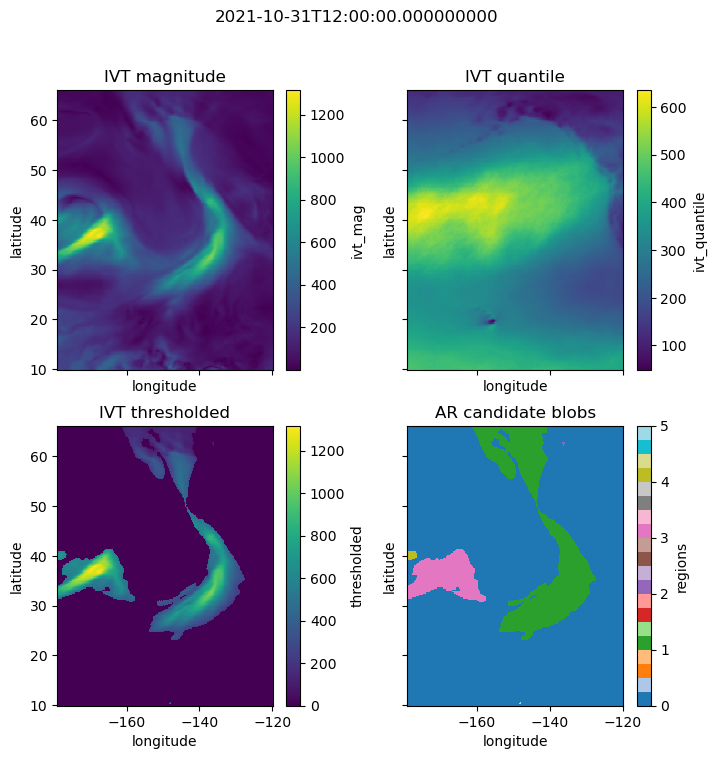

In [21]:
random_date = random.choice(list(output_ars.keys()))
fig, axes = plt.subplots(2, 2, sharey=True, sharex=True, figsize=(8,8))
plt.subplots_adjust(wspace=0.3)
plt.suptitle(random_date)

ivt_ds["ivt_mag"].sel(time=random_date).plot(ax=axes[0,0])
ivt_ds["ivt_quantile"].sel(time=random_date).plot(ax=axes[0,1])
ivt_ds["thresholded"].sel(time=random_date).plot(ax=axes[1,0])
labeled_regions.sel(time=random_date).plot(ax=axes[1,1], cmap="tab20")

axes[0,0].set_title("IVT magnitude")
axes[0,1].set_title("IVT quantile")
axes[1,0].set_title("IVT thresholded")
axes[1,1].set_title("AR candidate blobs")

In [22]:
%%time
# this may be a good target for dask
output_ar_gdf = create_geodataframe_with_all_ars(output_ars, ar_di, labeled_regions)
output_ar_gdf

CPU times: user 13 µs, sys: 0 ns, total: 13 µs
Wall time: 24.8 µs


In [11]:
create_shapefile(output_ar_gdf)

In [14]:
ivt_ds.close()